In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time

Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [44]:
Vizier.ROW_LIMIT = -1

cube_askap = SpectralCube.read('/Users/denes/Research/high_lat_HI/ASKAP_data/data_cubes/NGC4636_MW.fits')  # Open the FITS file for reading
askap = fits.open('/Users/denes/Research/high_lat_HI/ASKAP_data/data_cubes/NGC4636_MW.fits')  # Open the FITS file for reading
d_askap = askap[0].data
h_askap = askap[0].header
w_askap = WCS(h_askap, askap)

print(h_askap['CRVAL1'])
coordinate = '{}{}'.format(h_askap['CRVAL1'], h_askap['CRVAL2'])
c = SkyCoord(ra=h_askap['CRVAL1'],dec=h_askap['CRVAL2'], unit=(u.deg, u.deg))
print(c)

MRO = EarthLocation.of_site('mro') 
barycorr = c.radial_velocity_correction(obstime=Time('2019-10-25'), location=MRO) 
restfreq = 1.420405752 * u.GHz  # rest frequency of HI
freq_to_vel = u.doppler_optical(restfreq) # using the radio convention
vel_askap = (cube_askap.spectral_axis).to(u.km / u.s, equivalencies=freq_to_vel) - barycorr/2

#result = Vizier.query_constraints(catalog='VIII/81B/sumss212',RAJ2000='>{} & <{}'.format(c.ra.deg-19, c.ra.deg+19), DEJ2000='>{} & <{}'.format(c.dec.deg-3., c.dec.deg+3.), dMajAxis='<45', St='>140')
result = Vizier(column_filters={"S1.4":">500"}).query_constraints(catalog='VIII/65/nvss',RAJ2000='>{} & <{}'.format(c.ra.deg-3, c.ra.deg+3.3), DEJ2000='>{} & <{}'.format(c.dec.deg-9, c.dec.deg+3), MajAxis='<45')

print('number of sources:',len(result[0]))
#print(result[0]['RAJ2000'][0],result[0]['DEJ2000'][0])

detection = []
ra_0 = []
dec_0 = []

ra = []
dec = []

for i in range(len(result[0])):
    coord = '{} {}'.format(result[0]['RAJ2000'][i].replace(' ',':'),result[0]['DEJ2000'][i].replace(' ',':'))
    c2 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    pixels_askap = c2.to_pixel(w_askap)
    ra_0.append(c2.ra)
    dec_0.append(c2.dec)
    #print(coord )
    #print(pixels_askap)

    spectrum_askap = cube_askap[:, int(pixels_askap[1]), int(pixels_askap[0])]  # 10:09:10 -28:55:57
    tau_askap = np.log(spectrum_askap.value +1) * -1.
    rms = np.sqrt(np.mean(spectrum_askap.value**2))
    
    if abs(np.min(spectrum_askap.value)) > rms*4:
        detection.append(i)
        ra.append(c2.ra)
        dec.append(c2.dec)

        # plot
        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(111)
        ax.set_title('{}{}'.format(result[0]['RAJ2000'][i].replace(' ',':'),result[0]['DEJ2000'][i].replace(' ',':')), fontsize=20)

        plt.plot(vel_askap, spectrum_askap.value+1, 'C1', linewidth=3, label='ASKAP')
        ax.axhspan(1-rms, 1+rms, alpha=0.5, color='lightgrey')
        #plt.title('102809-264418', fontsize=30)
        plt.ylabel(r'e$^{-\tau}$', fontsize=28)
        plt.xlabel("v [km/s]", fontsize=28)
        plt.xlim(-200,200)
        #plt.ylim(0.92,1.02)
        plt.axhline(1, color='k', linestyle='--')
        #plt.legend(fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=25)
        fig.savefig('./spectra_plots/{}{}_ASKAP_spectra.png'.format(result[0]['RAJ2000'][i].replace(' ',''),result[0]['DEJ2000'][i].replace(' ','')))

print('4 sigma detections:', len(detection))    

189.0593916667
<SkyCoord (ICRS): (ra, dec) in deg
    (189.05939167, 5.39946111)>
number of sources: 10
4 sigma detections: 0


In [46]:
result[0]

NVSS,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,S1.4,e_S1.4,l_MajAxis,MajAxis,l_MinAxis,MinAxis,f_resFlux
,"""h:m:s""","""d:m:s""",s,arcsec,mJy,mJy,,arcsec,,arcsec,
bytes14,bytes11,bytes11,float32,float32,float64,float32,bytes1,float32,bytes1,float32,bytes2
122452+033050,12 24 52.44,+03 30 50.1,0.03,0.6,1280.3,38.4,<,18.7,<,16.5,
122521+033945,12 25 21.19,+03 39 45.3,0.03,0.6,503.0,17.7,,16.4,<,17.6,
122757-023700,12 27 57.40,-02 37 00.3,0.03,0.6,650.1,22.9,,14.8,<,18.9,P*
122800+072532,12 28 00.82,+07 25 32.3,0.03,0.6,505.0,16.7,,35.9,<,16.7,
122906+020305,12 29 06.41,+02 03 05.1,0.03,0.6,54991.2,1900.3,,21.5,<,15.9,P*
123200-022404,12 32 00.13,-02 24 04.1,0.03,0.6,1646.7,58.2,,14.1,<,19.2,
123205-013455,12 32 05.31,-01 34 55.1,0.03,0.6,807.4,24.2,<,19.7,<,17.0,P*
123911+051915,12 39 11.30,+05 19 15.1,0.03,0.6,534.1,18.6,,19.1,<,18.2,


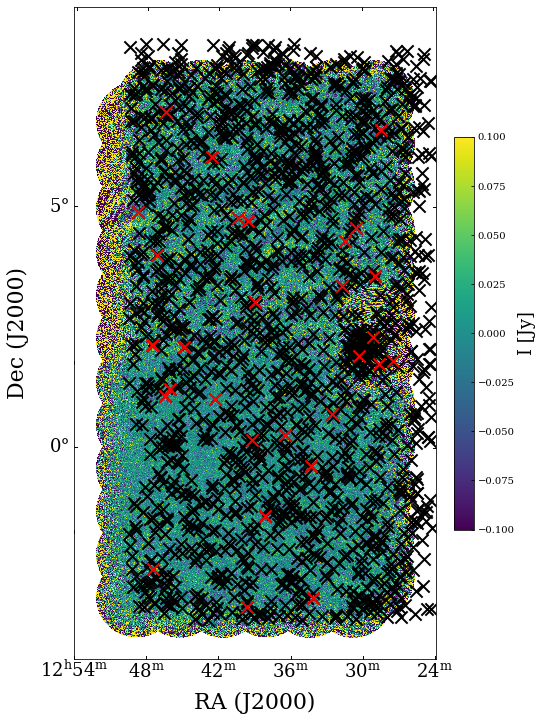

In [42]:
#hi_data = fits.open('/Users/denes/Research/high_lat_HI/ASKAP_data/Norma_cube_mom_0_-20-20kms.fits')  # Open the FITS file for reading
#hi_data = fits.open('/Users/denes/Research/high_lat_HI/ASKAP_data/large_cube_mom_0_140-160kms.fits')  # Open the FITS file for reading
hi_data = fits.open('/Users/denes/Research/high_lat_HI/ASKAP_data/NGC4636_cube_mom_0_-20-20kms.fits')  # Open the FITS file for reading

d = hi_data[0].data
h = hi_data[0].header

wcs = WCS(h)

fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(projection=wcs)
image = plt.imshow(d, cmap='viridis', vmax=np.percentile(d,90))

for j in range(0, len(ra_0)):
    ax.scatter(ra_0[j], dec_0[j], transform=ax.get_transform('fk5'), marker='x', s=150, linewidth=2, edgecolor='k', facecolor='k')

for i in range(0, len(ra)):
    ax.scatter(ra[i], dec[i], transform=ax.get_transform('fk5'), marker='x', s=150, linewidth=2, edgecolor='r', facecolor='r')

#ax.set_title('Hydra', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)
cbar_hi = plt.colorbar(image, orientation='vertical', fraction=0.022, pad=0.02)
cbar_hi.set_label('I [Jy]', size=18)

#overlay = ax.get_coords_overlay('galactic')
#overlay.grid(color='k', ls='dotted')
#overlay[0].set_axislabel('Galactic Longitude',fontsize=22)
#overlay[1].set_axislabel('Galactic Latitude',fontsize=22)

#ax.set_xlim(x_lim)
#ax.set_ylim(y_lim)

fig.savefig('NGC4636_detections.png', dpi=200, bbox_inches='tight')



In [41]:
result[0].keys()


['NVSS',
 'RAJ2000',
 'DEJ2000',
 'e_RAJ2000',
 'e_DEJ2000',
 'S1.4',
 'e_S1.4',
 'l_MajAxis',
 'MajAxis',
 'l_MinAxis',
 'MinAxis',
 'f_resFlux']